# Mixture Out  of Disterbution

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import copy
import seaborn as sns
import sys
from scipy.interpolate import make_interp_spline, BSpline
%run ./result_summary.ipynb
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')

output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from analyze_utilities import *
from mixture_utilities import *
from distributions_metrics import *
plt = double_column_plt_params(plt)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Load svhn and noise
results_df_cifar10, statistic_cifar10 = load_results_to_df(files_nml_2_layers)
results_dict = load_dict_from_file_list(files_nml_2_layers)
mixture_df_cifar10 = create_mixture_df(results_dict)
print('Cifar10: loaded %d keys' % results_df_cifar10.shape[0])
results_df_noise, statistic_noise = load_results_to_df(
    files_noise, is_out_of_dist=True)
results_dict = load_dict_from_file_list(files_noise)
mixture_df_noise = create_mixture_df(results_dict)
print('Noise: loaded %d keys' % results_df_noise.shape[0])
results_df_svhn, statistic_svhn = load_results_to_df(
    files_svhn, is_out_of_dist=True)
results_dict = load_dict_from_file_list(files_svhn)
mixture_df_svhn = create_mixture_df(results_dict)
print('SVHN: loaded %d keys' % results_df_svhn.shape[0])

  0%|          | 0/100 [00:00<?, ?it/s]

Cifar10: loaded 10000 keys


 13%|█▎        | 13/100 [00:00<00:00, 122.32it/s]

Noise: loaded 100 keys


100%|██████████| 100/100 [00:00<00:00, 114.98it/s]

SVHN: loaded 100 keys


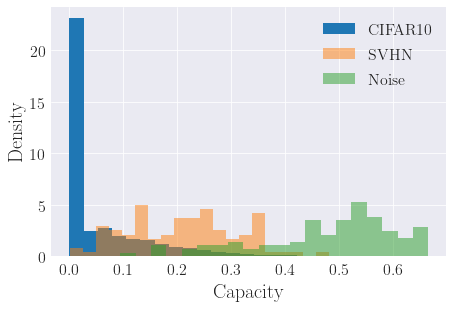

Mean: cifar, svhn, noise: [0.052227198194001026, 0.21101390012476615, 0.476977559288566]


In [4]:
# Plot
bins = 20
plt.hist(mixture_df_cifar10['capacity'].tolist(),
         alpha=1, density=True, label='CIFAR10', bins=bins)
plt.hist(mixture_df_svhn['capacity'].tolist(),
         alpha=0.5, density=True, label='SVHN', bins=bins)
plt.hist(mixture_df_noise['capacity'].tolist(),
         alpha=0.5, density=True, label='Noise', bins=bins)
plt.ylabel('Density')
plt.xlabel('Capacity')
plt.title('Out Of Distribution Capacity Histogram') if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_mixture_out_of_dist_capacity_hist.pdf'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()
print('Mean: cifar, svhn, noise: {}'.format([mixture_df_cifar10['capacity'].mean(),
                                             mixture_df_svhn['capacity'].mean(),
                                             mixture_df_noise['capacity'].mean()]))

## Evaluation metrics

Upsample ratio:  100
Noise:
             KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob             0.794              0.188         0.192
1-p2/p1              0.643              0.162         0.164
1 - Entropy          3.369              0.349         0.373
Capacity             5.798              0.893         0.893



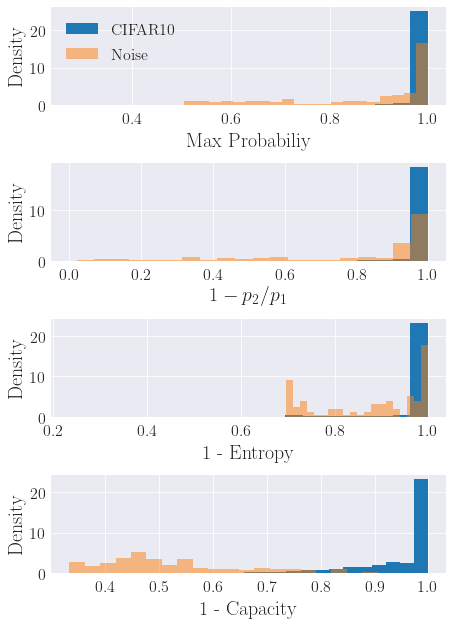

Upsample ratio:  100
SVHN:
             KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob             0.777              0.189         0.192
1-p2/p1              0.701              0.152         0.153
1 - Entropy          1.700              0.341         0.344
Capacity             1.887              0.458         0.461



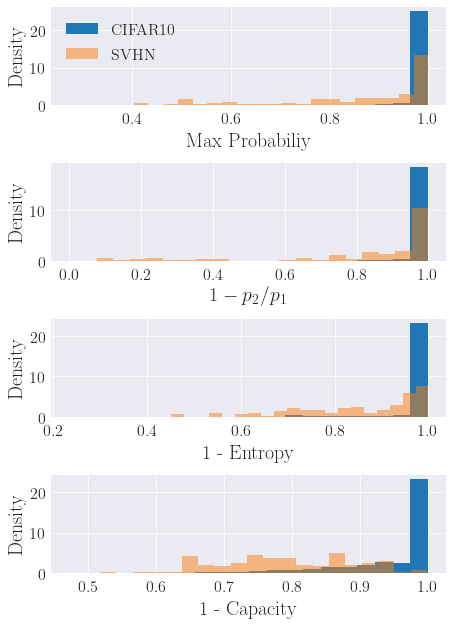

In [6]:
from numpy import inf
ind_df = results_df_cifar10
ind_mixture_df = mixture_df_cifar10
total_subplots = 4
for (ooo_dataset, ood_df, ood_mixture_df) in zip(['Noise', 'SVHN'],
                                                 [results_df_noise,
                                                     results_df_svhn],
                                                 [mixture_df_noise, mixture_df_svhn]):
    upsample_ratio = int(ind_df.shape[0] / ood_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)

    # Baseline Max prob of ERM
    y_score_ind = ind_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
        ood_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline = ood_df_erm_baseline.rename(index={0: 'Max Prob'})

    # Baseline p1/p2 of ERM
    p1_ind = np.sort(ind_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 1]
    p2_ind = np.sort(ind_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 0]
    p1_p2_ind = 1-p2_ind/p1_ind  # np.clip(p1_ind/p2_ind, 0, 10**6)
    p1_ood = np.sort(ood_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 1]
    p2_ood = np.sort(ood_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 0]
    p1_p2_ood = 1-p2_ood/p1_ood  # np.clip(p1_ood/p2_ood, 0, 10**6)

    y_score_ind = list(p1_p2_ind) + list(p1_p2_ood)
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline_2 = calc_performance_in_out_dist(
        y_true_ind, y_score_ind)
    ood_df_erm_baseline_2 = ood_df_erm_baseline_2.rename(index={0: '1-p2/p1'})

    # Entropy
    y_score_ind = (1.0 - ind_df['erm_entropy']).tolist() + \
        (1.0 - ood_df['erm_entropy']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline_3 = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline_3 = ood_df_erm_baseline_3.rename(index={0: '1 - Entropy'})

    # Capacity based
    y_score_ind = ind_mixture_df['capacity'].tolist() + \
        ood_mixture_df['capacity'].tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Capacity'})

    # Summary
    merged_pd = pd.concat(
        [ood_df_erm_baseline,
         ood_df_erm_baseline_2,
                  ood_df_erm_baseline_3,
         ood_df_ours])
    print('%s:' % ooo_dataset)
    print(merged_pd.round(3))
    print()

    # Histogram based on Ouf Of Dist confidence
    sub_num = 0
    width, height = plt.rcParams.get('figure.figsize')
    f, axarr = plt.subplots(total_subplots, 1, figsize=(
        width, (1 + 0.25*total_subplots)*height))
    nbins = 20
    axarr[sub_num].hist(ind_df[['erm_' + str(x) for x in range(10)]
                               ].max(axis=1),  bins=nbins, alpha=1.0, density=True, label='CIFAR10')
    axarr[sub_num].hist(ood_df[['erm_' + str(x) for x in range(10)]
                               ].max(axis=1),  bins=nbins, alpha=0.5, density=True, label=ooo_dataset)
    axarr[sub_num].set_xlabel('Max Probabiliy')
    axarr[sub_num].set_ylabel('Density')
    axarr[sub_num].legend()
    sub_num += 1

    axarr[sub_num].hist(list(p1_p2_ind), bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[sub_num].hist(list(p1_p2_ood), bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[sub_num].set_xlabel(r'$1-p_2 / p_1$')
    axarr[sub_num].set_ylabel('Density')
    sub_num += 1

    axarr[sub_num].hist(list(1 - ind_df['erm_entropy']), bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[sub_num].hist(list(1 - ood_df['erm_entropy']), bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[sub_num].set_xlabel(r'1 - Entropy')
    axarr[sub_num].set_ylabel('Density')
    sub_num += 1

    axarr[sub_num].hist(1 - ind_mixture_df['capacity'], bins=nbins,
                        alpha=1.0, density=True, label='In-Dist')
    axarr[sub_num].hist(1 - ood_mixture_df['capacity'], bins=nbins,
                        alpha=0.5, density=True, label=ooo_dataset)
    axarr[sub_num].set_xlabel('1 - Capacity')
    axarr[sub_num].set_ylabel('Density')

    f.subplots_adjust(hspace=0.6)
    plt.savefig(os.path.join(output_path, 'figure_mixture_out_of_dist_capacity_detection_%s.pdf' % ooo_dataset),
                dpi=300, bbox_inches=plt.tight_layout()) if is_save_fig else None
    plt.show()
